# MXNET

---

Student:<br>
Đinh Vũ Gia Hân - 22127098<br>
Đỗ Lê Khoa - 22127195

## Library

In [1]:
import time
import pickle
import tracemalloc
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score
import mxnet as mx
from mxnet import gluon, autograd, nd
from mxnet.gluon import nn
from mxnet.gluon.data import DataLoader, ArrayDataset
from mxnet.gluon.loss import SoftmaxCrossEntropyLoss

## Load data

The first step is to load the preprocessed data.

In [2]:
with open('../data/preprocessed_data.pkl', 'rb') as f:
    X_train, y_train, X_val, y_val, X_test, y_test = pickle.load(f)

Because `MXNet Gluon` support label in type of integer, we convert them to numerical values.

In [3]:
y_train = np.argmax(y_train, axis=1)
y_val = np.argmax(y_val, axis=1)
y_test = np.argmax(y_test, axis=1)

## Design model

We will construct the model with the following architecture:
- Hidden Layers: Two layers with 256 and 128 neurons, respectively.
- Activation Function: ReLU (Rectified Linear Unit).
- Optimizer: Adam.
- Batch Size: 128.
- Learning Rate: Initial value of 0.001, decreasing by 0.1% every 10 epochs.
- Maximum Iterations: 200.
- Early Stopping: Stop training if the loss does not improve within 10 epochs.

**ReLU Activation Function**

The formula for the ReLU (Rectified Linear Unit) activation function is:

$$
f(x) = \max(0, x)
$$

**Explanation**:
- If \(x $>$ 0\), the output is \(x\).
- If \(x $\leq$ 0\), the output is \(0\).

ReLU helps introduce non-linearity into the network and avoids the vanishing gradient problem commonly encountered with Sigmoid or Tanh activations.


In [4]:
# Hyperparameters
initial_lr = 0.001             # Initial learning rate
patience = 10                  # Early stopping patience
min_delta = 0.001              # Minimum improvement to reset patience
best_val_loss = float('inf')   # Best validation loss
epochs_no_improve = 0          # Count epochs with no improvement
max_epoch = 200                # Maximum epochs
decay_epochs = 10              # Decay learning rate after X epochs
batch_size = 128               # Batch size

# Build the model
class MLPClassifier(nn.Block):
    def __init__(self):
        super(MLPClassifier, self).__init__()
        self.net = nn.Sequential()
        self.net.add(
            nn.Dense(256, activation='relu'),
            nn.Dense(128, activation='relu'),
            nn.Dense(10)  
        )
    def forward(self, x):
        return self.net(x)
    
# Check if GPU is available
device = mx.gpu() if mx.context.num_gpus() > 0 else mx.cpu()
print(f"Using device: {device}")

# Initialize the model
model = MLPClassifier()
model.initialize(mx.init.Xavier(), ctx=device)

Using device: cpu(0)


## Selecting Loss Function and Optimizer

We will utilize `CrossEntropyLoss` for loss function. For optimization, we chose the `Adam` optimizer with a learning rate of 0.001, ensuring efficient and adaptive gradient updates. Additionally, we will reduce the learning rate by a factor of 0.1 every 10 epochs to improve convergence during training.

## CrossEntropyLoss

The formula for CrossEntropyLoss is as follows:

$$
\text{Loss} = -\frac{1}{N} \sum_{i=1}^{N} \sum_{j=1}^{C} y_{ij} \log(\hat{y}_{ij})
$$

1. **Input**: The logits produced by the model $z_i$.
2. **SoftMax Transformation**: Converts logits into probabilities:
   $$
   \hat{y}_{ij} = \frac{e^{z_{ij}}}{\sum_{k=1}^{C} e^{z_{ik}}}
   $$
3. **Loss Calculation**: The negative log of the predicted probability corresponding to the ground truth class is summed and averaged across all samples.

**Explain**:
It calculates the negative log of the predicted probability corresponding to the true class for each sample and the average loss is computed across the entire dataset. The objective is to minimize the loss, indicating that the model's predictions are getting closer to the true labels.

---

Adam Optimizer

The Adam optimizer updates weights using the following formulas:

### Moment Estimation:
$$
m_t = \beta_1 m_{t-1} + (1 - \beta_1) g_t
$$
$$
v_t = \beta_2 v_{t-1} + (1 - \beta_2) g_t^2
$$

### Bias Correction:
$$
\hat{m}_t = \frac{m_t}{1 - \beta_1^t}, \quad \hat{v}_t = \frac{v_t}{1 - \beta_2^t}
$$

### Weight Update:
$$
 \theta_t = \theta_{t-1} - \frac{\eta}{\sqrt{\hat{v}_t} + \epsilon} \hat{m}_t
$$
1. **Input**: Gradients ($g_t$) calculated during backpropagation.
2. **Moment Calculation**:
   - First moment $m_t$ tracks the mean of past gradients to smooth updates.
   - Second moment $v_t$ tracks the variance to adjust the learning rate dynamically.
3. **Bias Correction**: Corrects for initialization bias in the first few iterations.
4. **Weight Update**: Parameters are updated based on the adjusted learning rates and directions determined by the moments.
<br><br>**Explain**:
- Adam uses two moment estimates:
First Moment (Momentum): stores the exponentially weighted moving average of past gradients.
Second Moment (Variance): stores the exponentially weighted moving average of squared gradients, adjusting the learning rate accordingly.
- Bias Correction: Both moment estimates are bias-corrected to avoid skewed updates, especially in the early stages of training.
- Weight Update: The weights are updated using the bias-corrected moments, with an adaptive learning rate for each parameter.
- Adam combines momentum and adaptive learning rates, helping the model converge faster and more stably during training.

In [5]:
# Loss function và optimizer
criterion = SoftmaxCrossEntropyLoss()
trainer = gluon.Trainer(model.collect_params(), 'adam', {'learning_rate': initial_lr})

## Model Training

In [6]:
# DataLoader
train_dataset = ArrayDataset(nd.array(X_train), nd.array(y_train))
val_dataset = ArrayDataset(nd.array(X_val), nd.array(y_val))

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Training variables
train_losses = []
val_losses = []
val_accuracies = []

# Start measuring the time and memory
start_time = time.time()
tracemalloc.start()

# Training loop
for epoch in range(max_epoch):
    train_loss = 0.0

    # Train the model
    for data, label in train_loader:
        data = data.as_in_context(device)
        label = label.as_in_context(device)

        with autograd.record():
            output = model(data)
            loss = criterion(output, label)
        loss.backward()
        trainer.step(batch_size)

        train_loss += loss.mean().asscalar()

    # Calculate average losses
    avg_train_loss = train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Validate the model
    val_loss = 0.0
    correct = 0
    total = 0

    # Validation loop
    for data, label in val_loader:
        data = data.as_in_context(device)
        label = label.as_in_context(device)

        output = model(data)
        loss = criterion(output, label)
        val_loss += loss.mean().asscalar()

        predictions = nd.argmax(output, axis=1)
        correct += (predictions == label).sum().asscalar()
        total += label.size

    # Calculate average losses and accuracies
    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    val_accuracy = (correct / total) * 100
    val_accuracies.append(val_accuracy)

    # Print the progress
    print(f"Epoch {epoch + 1}/{max_epoch}, Train Loss: {avg_train_loss:.4f}, "
        f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

    # Early Stopping
    if avg_val_loss < best_val_loss - min_delta:
        best_val_loss = avg_val_loss
        epochs_no_improve = 0
        # model.save_parameters("best_model.params")
        print("Validation loss improved. Saving model...")
    else:
        epochs_no_improve += 1
        print(f"No improvement for {epochs_no_improve} epochs.")

    # Check early stopping condition
    if epochs_no_improve >= patience:
        print("Early stopping triggered!")
        break

    # Learning rate decay
    if (epoch + 1) % decay_epochs == 0:
        new_lr = trainer.learning_rate * 0.1
        trainer.set_learning_rate(new_lr)

# Stop measuring time and memory
end_time = time.time()
current, peak = tracemalloc.get_traced_memory()
tracemalloc.stop()

Epoch 1/200, Train Loss: 1.9215, Validation Loss: 1.8519, Validation Accuracy: 33.83%
Validation loss improved. Saving model...
Epoch 2/200, Train Loss: 1.7228, Validation Loss: 1.7141, Validation Accuracy: 38.98%
Validation loss improved. Saving model...
Epoch 3/200, Train Loss: 1.6429, Validation Loss: 1.6501, Validation Accuracy: 41.19%
Validation loss improved. Saving model...
Epoch 4/200, Train Loss: 1.5864, Validation Loss: 1.6676, Validation Accuracy: 40.42%
No improvement for 1 epochs.
Epoch 5/200, Train Loss: 1.5447, Validation Loss: 1.6316, Validation Accuracy: 42.09%
Validation loss improved. Saving model...
Epoch 6/200, Train Loss: 1.5113, Validation Loss: 1.5421, Validation Accuracy: 45.35%
Validation loss improved. Saving model...
Epoch 7/200, Train Loss: 1.4824, Validation Loss: 1.6042, Validation Accuracy: 44.00%
No improvement for 1 epochs.
Epoch 8/200, Train Loss: 1.4687, Validation Loss: 1.5395, Validation Accuracy: 45.80%
Validation loss improved. Saving model...
Ep

In [7]:
# Calculate the training time
training_time = end_time - start_time
print(f"Training time: {training_time:.2f} seconds")

Training time: 222.60 seconds


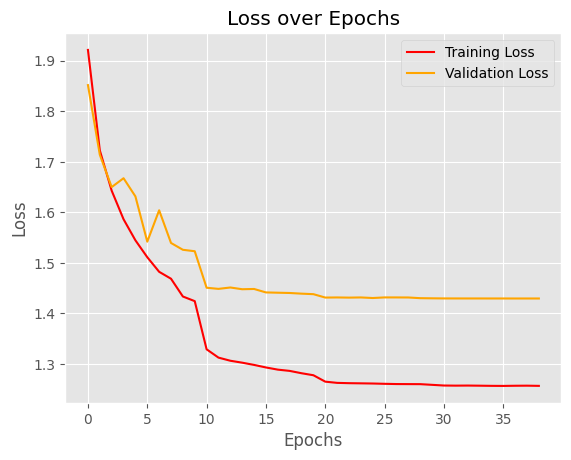

In [8]:
plt.plot(train_losses, label='Training Loss', color='red')
plt.plot(val_losses, label='Validation Loss', color='orange')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

In [9]:
# Print the memory usage
print(f"Current memory usage: {current / 10**6:.2f} MB")
print(f"Peak usage: {peak / 10**6:.2f} MB")

Current memory usage: 0.67 MB
Peak usage: 0.90 MB


## Model Evaluation

Accuracy: 0.5056
Precision: 0.5021
Recall: 0.5056
F1 Score: 0.5028


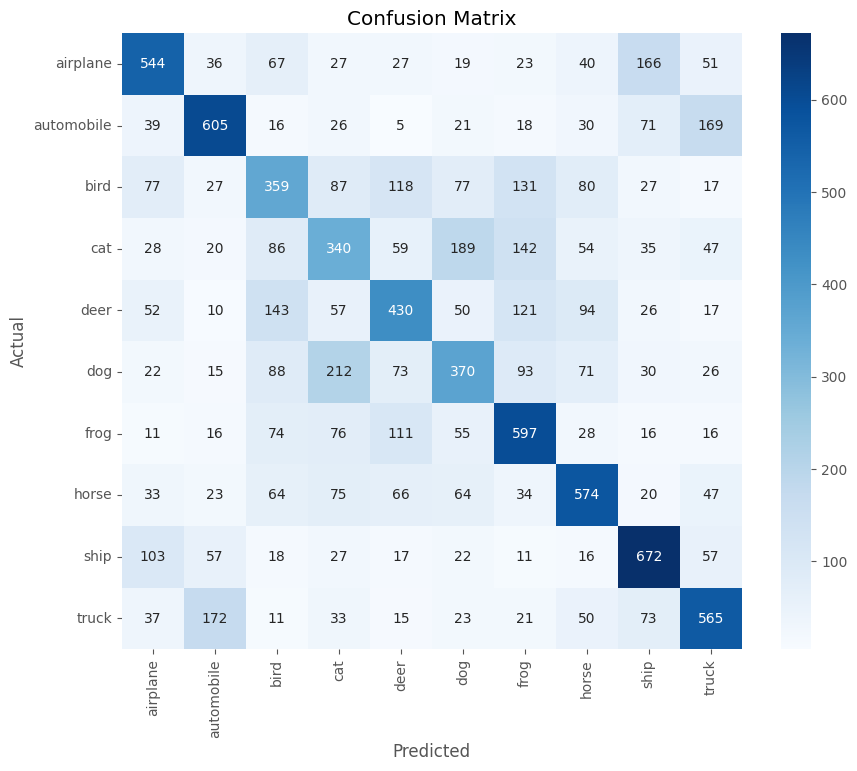

In [10]:
# Convert the test data to NDArray
X_test = nd.array(X_test).as_in_context(device)
y_test = nd.array(y_test).as_in_context(device)

# Predict the test data
output = model(X_test)
predictions = nd.argmax(output, axis=1)

# Convert the predictions and true labels to NumPy arrays
predictions = predictions.asnumpy()
y_test = y_test.asnumpy()

# Calculate the evaluation metrics
accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions, average='weighted')
recall = recall_score(y_test, predictions, average='weighted')
f1 = f1_score(y_test, predictions, average='weighted')

# Print the evaluation metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Plot the confusion matrix
cm = confusion_matrix(y_test, predictions)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[
    "airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"
], yticklabels=[
    "airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"
])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

## Futher Usage

In [11]:
# Save the model
model.save_parameters('mxnet_model.params')

# Load the model
model = MLPClassifier()
model.initialize(mx.init.Xavier(), ctx=device)
model.load_parameters('mxnet_model.params', ctx=device)

Text(0.5, 1.0, 'Predicted: \n[3.]\n<NDArray 1 @cpu(0)> - Actual: 3.0')

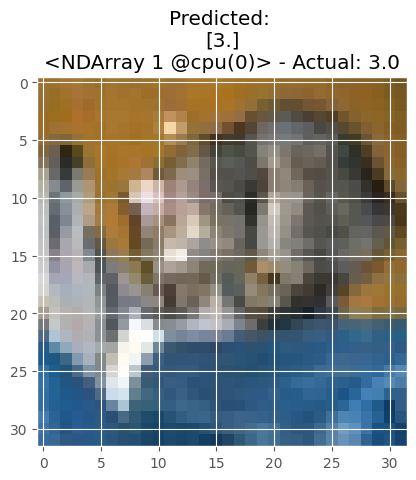

In [12]:
single_image = nd.array(X_test[0]).as_in_context(device)  # first image in test
output = model(single_image.expand_dims(0)) 
predictions = nd.argmax(output, axis=1)
plt.imshow(single_image.reshape(32, 32, 3).asnumpy())  
plt.title(f'Predicted: {predictions[0]} - Actual: {y_test[0]}')